**Author**: [Aakash Kumar Nain](https://twitter.com/A_K_Nain) <br/>
**Date Created**: 2022/07/28 <br/>
**Last Modified**: 2022/08/03 <br/>
**Description**: All you need to know about Gaussian Distribution

In [1]:
import os
import scipy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots


seed = 1234
np.random.seed(seed)
plt.style.use("seaborn")

%config IPCompleter.use_jedi = False
%config InlineBackend.figure_format='png'
%matplotlib inline

In [2]:
SAVE_PLOT_DIR = "plots"
if not os.path.exists(SAVE_PLOT_DIR):
    os.mkdir(SAVE_PLOT_DIR)

Today we will talk about the **Gaussian Distribution** and its importance in understanding the **Denoising Diffusion Models** or **DDPMs** for short.

We will cover the maths behind these concepts and will code them along the way. IMO the maths looks much scarier when presented in equations, but it becomes simple once you look at the code implementation. So, don't be scared by the greek symbols used in the equations. Try to undersatnd the code. It will help you understand the concepts better. Also, most of the visualizations presented in this notebook are interactive. Without further ado, let's start!

# 1. Normal Distribution

Also known as **Gaussian** Distribution, the normal distribution is one of the most widely used continuous probability distributions. The notation, $\mathcal{N}(\mu, \sigma^{2})$ , is commonly used to refer to a normal distribution. 

The parameter $\mu$ represents the **mean** or **expected value** of the distribution, while the parameter $\sigma$ is its **standard deviation**. The **variance** of the distribution is $\sigma^{2}$

For a real-valued random variable `x`, the probability density function is defined as:
$$
p(x; \mu, \sigma^{2}) = \frac{1}{\sigma \sqrt{2 \pi}} exp({\frac{-1}{2}(\frac {x - \mu}{\sigma})^{2}}) \tag {1}
$$


# 1.1 Univariate Normal Distribution

When we deal with only one random variable, e.g. `x` in the above equation, we call the distribution a univariate normal distribution. Let's code up the above equation and take an example of a univariate normal distribution.

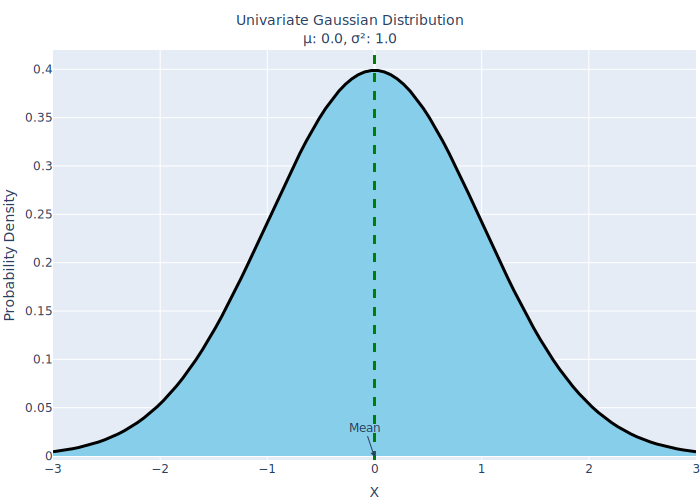

In [3]:
def get_univariate_normal(x, mu, sigma):
    """Generates a PDF for a Univariate Normal Distribution.

    Args:
        x: Vector of values sorted in ascending order
        mu: Mean of the Gaussian
        sigma: Standard Deviation of the Gaussian
    Returns:
        A PDF
    """
    return 1 / (sigma * np.sqrt(2 * np.pi)) * (np.exp(-(x - mu)**2 / (2 * sigma**2)))


# Mean of the distribution
mu = 0.0

# Standard deviation(SD for short)
sigma = 1.0

# Generate a linspace for a random variable x
num_samples = 100
x = np.linspace(-3*sigma + mu, 3*sigma + mu, num=num_samples)

# Plot the value against the PDF
fig = go.Figure(
    data=go.Scatter(
        x=x,
        y=get_univariate_normal(x, mu=mu, sigma=sigma),
        line=dict(width=3,color="black"),
        fill="tonexty",
        fillcolor="skyblue",
    )
)

fig.add_annotation(x=mu, y=-0.001, text="Mean",showarrow=True, arrowhead=2)
fig.add_vline(x=mu, line_width=3, line_dash="dash", line_color="green")
fig.update_layout(
    {
        "title": {
            'text': f"Univariate Gaussian Distribution <br> μ: {mu}, σ\u00b2: {sigma**2}",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=14)
        },
        "xaxis": {"title": "X"},
        "yaxis": {"title": "Probability Density"},
        "margin": dict(l=0, r=0, b=0, t=50)
    }
)

fig.write_html(os.path.join(SAVE_PLOT_DIR, "univariate_normal_example.html"))
fig.write_image(os.path.join(SAVE_PLOT_DIR, "univariate_normal_example.png"))
fig.show("svg")

Moving the mean value shifts the distribution from right to left while changing sigma affects the shape of the distribution. As the value of sigma increases, the curve gets more and more flat. Let's see that in action.

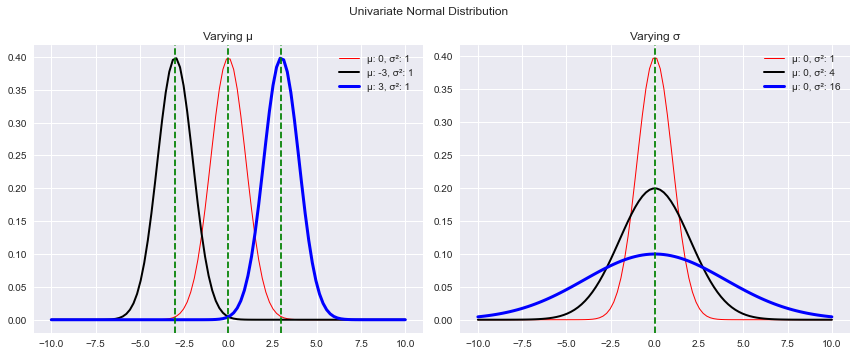

In [4]:
# Moving the mean shifts the distribution to
# right/left while increasing/decresasing the
# variance makes the curve more flat/pointy respectively
# Let's take an example to see this in action

# Random variable x
x = np.linspace(-10.0, 10.0, 100)

# Combination of mu and sigma. The first value
# of any tuple represents mu while the second value
# represents sigma here.
mu_sigma_combos = [
    [(0, 1), (-3, 1), (3, 1)],
    [(0, 1), (0, 2), (0, 4)],
]

# Line colors and widths to be used
# for different combinations
colors = ["red", "black", "blue"]
widths = [1, 2, 3]
subtitles = ["Varying μ", "Varying σ"]

# Plot
_, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 5), tight_layout=True)
for i, elem in enumerate(mu_sigma_combos):
    legend = []
    mus = set()
    for j, comb in enumerate(elem):
        mu, sigma = comb
        mus.add(mu)
        legend.append(f"μ: {mu}, σ\u00b2: {sigma**2}")
        ax[i].plot(x, get_univariate_normal(x, mu, sigma), linewidth=widths[j], c=colors[j])
        ax[i].tick_params(labelbottom=True)
    
    ax[i].set_title(subtitles[i])
    ax[i].legend(legend, loc="upper right")
    
    for mu in mus:
        ax[i].axvline(x=mu, color="green", linestyle="--")

plt.suptitle("Univariate Normal Distribution")
plt.savefig(
    os.path.join(SAVE_PLOT_DIR, "univariate_with_dff_mu_sigma.png"),
    bbox_inches='tight'
)
plt.show()

# 1.2 Multivariate Normal Distribution

Multivariate normal distribution is the extension of univariate normal distribution to the case where we deal with a real-valued **vector input** instead of a single real-valued random variable. Like in the univariate case, the multivariate normal distribution has associated parameters $\mu$ representing the **mean vector** and $\Sigma$ representing the **covariance matrix**.

This is the probability density function for multivariate case:
$$
p(x; \mu, \Sigma) = \frac{1}{(2\pi)^{d/2} \ \vert{\Sigma}\vert^{1/2}} \ exp \ (\frac{-1}{2}(x - \mu)^T \Sigma^{-1}(x - \mu))  \tag{2}
$$

* Random Variable $X = [x_{1}, \ x_{2}, \ x_{3}...]$ is a `D`-dimensional vector
* Mean $\mu = [\mu_{1}, \ \mu_{2}, \ \mu_{3}...]$ is a `D`-dimensional vector
* Covariance Matrix $\Sigma$ is a `D X D` dimensional matrix


If the vector `X` is 2-dimensional, then that distribution is also known as **Bivariate Normal Distribution**.

**Note:** We need two dimensions to visualize a univariate Gaussian, and three dimensions to visualize a bivariate Gaussian. Hence for visualization purposes, we will show everything with a *bivariate* Gaussian, which then, can be extended to *multivariate* cases. Let's visualize a bivariate Gaussian. We will use `scipy.stats.multivariate_normal` to generate the probability density.

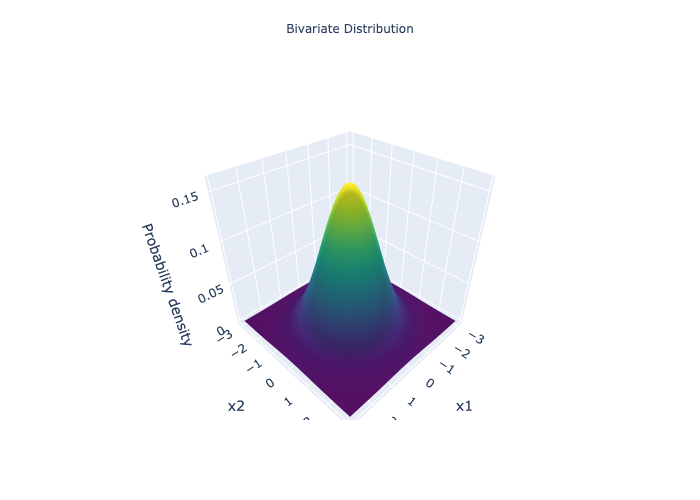

In [5]:
def get_multivariate_normal(
    mu,
    cov,
    sample=True,
    sample_size=None,
    seed=None,
    gen_pdf=False,
    pos=None
):
    """Builds a multivariate Gaussian Distribution.
    
    Given the mean vector and the covariance matrix,
    this function builds a multivariate Gaussian
    distribution. You can sample from this distribution,
    and generate probability density for given positions.
    
    Args:
        mu: Mean vector representing the mean values for
            the random variables
        cov: Covariance Matrix
        sample (bool): If sampling is required
        sample_size: Only applicable if sampling is required.
            Number of samples to extract from the distribution
        seed: Random seed to be passed for distribution, and sampling
        gen_pdf(bool): Whether to generate probability density
        pos: Applicable only if density is generated. Values for which
            density is generated
    Returns:
        1. A Multivariate distribution
        2. Sampled data if `sample` is set to True else `None`
        3. Probability Density if `gen_pdf` is set to True else `None`
    """
    
    # 1. Multivariate distribution from given mu and cov
    dist = multivariate_normal(mean=mu, cov=cov, seed=seed)
    
    # 2. If sampling is required
    if sample:
        samples = dist.rvs(size=sample_size, random_state=seed)
    else:
        samples = None
    
    # 3. If density is required
    if gen_pdf:
        if pos is None:
            raise ValueError("`pos` is required for generating density!")
        else:
            pdf = dist.pdf(pos)
    else:
        pdf = None
        
    return dist, samples, pdf



# Mean of the random variables X1 and X2
mu_x1, mu_x2 = 0, 0

# Standard deviation for the random variables X1 and X2
sigma_x1, sigma_x2 = 1, 1

# Positions for which probability density is
# to be generated
x1, x2 = np.mgrid[
    (-3.0 * sigma_x1 + mu_x1):(3.0 * sigma_x1 + mu_x1): 0.1,
    (-3.0 * sigma_x2 + mu_x2):(3.0 * sigma_x2 + mu_x2): 0.1
]
pos = np.dstack((x1, x2))

# Mean vector
mu = [mu_x1, mu_x2]

# Covariance between the two random variables
cov_x1x2 = 0

# Covariance Matrix for our bivariate Gaussian distribution
cov = [[sigma_x1**2, cov_x1x2], [cov_x1x2, sigma_x2**2]]

# Build distribution generate density
sample = get_multivariate_normal(
        mu=mu,
        cov=cov,
        sample=False,
        seed=seed,
        gen_pdf=True,
        pos=pos
    )


# Plot the bivariate normal density
fig = go.Figure(
    go.Surface(
        z=sample[2],
        x=x1,
        y=x2,
        colorscale='Viridis',
        showscale=False
    )
)
fig.update_layout(
    {
        "title": dict(
            text="Bivariate Distribution",
            y=0.95,
            x=0.5,
            xanchor="center",
            yanchor="top",
            font=dict(size=12)
        ), 
        "scene":dict(
            xaxis=dict(title='x1'),
            yaxis=dict(title='x2'),
            zaxis=dict(title='Probability density')
        ),
        "xaxis": dict(title="Values"),
        "yaxis": dict(title="Probability Density"),
    }
)
fig.write_html(os.path.join(SAVE_PLOT_DIR, "bivariate_normal_example.html"))
fig.write_image(os.path.join(SAVE_PLOT_DIR, "bivariate_normal_example.png"))
fig.show("png")

[Click here](https://aakashkumarnain.github.io/images/images_from_other_repos/diffusion_models/plots/bivariate_normal_example.html) for an **interactive plot**. You can zoom in/out, and rotate the surface to see what the Gaussians look like. When you hover over the density, you will see black lines generating two univariate normals, one for `x1` and another for `x2`


# 2. Covariance

In the last section, we introduced the term `covariance matrix`. Before we move on to the next section, it is important to understand the concept of covariance. 

Let's say `X` and `Y` are two random variables. Covariance of `X` and `Y` is defined as:

$$
Cov(X, Y) = E[(X - E(X))(Y - E(Y))] = E[XY] - E[X]E[Y]  \tag{3}
$$

i.e. the covariance is the expected value of the product of their deviations from their individual expected values.


So, what does **covariance** tell us? A lot...

1. Covariance gives a sense of how much two random variables as well their scales are **linearly** related
2. Covariance captures only linear dependence and gives no information about other kind of relationships
3. If the sign of the covariance is positive, then both variables tend to take on relatively high values simultaneously. If the sign of the covariance is negative, then one variable tends to take on a relatively high value at the times that the other takes on a relatively low value and vice versa.
4. If two variables `X` and `Y` are **independent**, then $Cov(X, Y)= 0$ but the reverse isn't true. Why? Because covariance doesn't take into account non-linear relationships

# 2.1 Covariance Matrix

If `X` is a `N`-dimensional vector i.e. $X = [x_{1}, \ x_{2}, \ x_{3}...x_{n}]$, the covariance matrix is a `N`X`N` matrix defined as:

$$
\begin{bmatrix}
Cov(x_{1}x_{1}) & \cdots & Cov(x_{1}x_{n}) \\
\vdots & \ddots & \vdots \\
Cov(x_{n}x_{1}) & \cdots & Cov(x_{n}x_{n})
\end{bmatrix}
$$

Each entry $(i, j)$ in this matrix defines the covariance of two random variables of the vector. Also:

$$
Cov(x_{i}x_{j}) = Var(x_{i}) \ \ \ \{ i=j\}
$$

Let's take an example to showcase zero covariance, positive covariance, and negative covariance between two random variables `x1` and `x2`

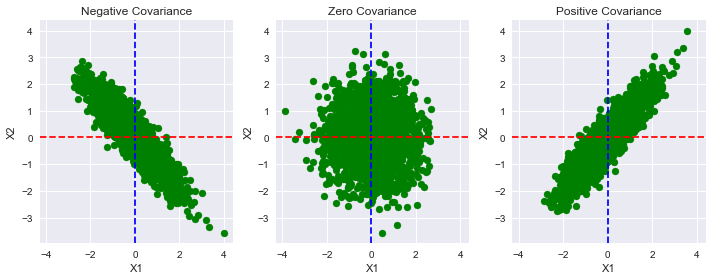

In [6]:
# Mean of the random variables X1 and X2
mu_x1, mu_x2 = 0, 0

# Standard deviation of the random variables X1 and X2
sigma_x1, sigma_x2 = 1, 1

# Number of samples to extract
sample_size = 2000

# Positions for which probability density is
# to be generated
x1, x2 = np.mgrid[
    (-3.0 * sigma_x1 + mu_x1):(3.0 * sigma_x1 + mu_x1): 0.1,
    (-3.0 * sigma_x2 + mu_x2):(3.0 * sigma_x2 + mu_x2): 0.1
]
pos = np.dstack((x1, x2))

# Mean vector
mu = [mu_x1, mu_x2]


# Case 1: Zero Covariance
cov_x1x2 = 0
zero_cov = [[sigma_x1**2, cov_x1x2], [cov_x1x2, sigma_x2**2]]
# Build distribution, sample and generate density
zero_cov_res = get_multivariate_normal(
        mu=mu,
        cov=zero_cov,
        sample=True,
        sample_size=sample_size,
        seed=seed,
        gen_pdf=True,
        pos=pos
    )


# Case 2: Positive Covarinace
cov_x1x2 = 0.9
pos_cov = [[sigma_x1**2, cov_x1x2], [cov_x1x2, sigma_x2**2]]
# Build distribution, sample and generate density
pos_cov_res = get_multivariate_normal(
        mu=mu,
        cov=pos_cov,
        sample=True,
        sample_size=sample_size,
        seed=seed,
        gen_pdf=True,
        pos=pos
    )


# Case 3: Negative Covarinace
cov_x1x2 = -0.9
neg_cov = [[sigma_x1**2, cov_x1x2], [cov_x1x2, sigma_x2**2]]
# Build distribution, sample and generate density
neg_cov_res = get_multivariate_normal(
        mu=mu,
        cov=neg_cov,
        sample=True,
        sample_size=sample_size,
        seed=seed,
        gen_pdf=True,
        pos=pos
    )

# Plot the covariances
_, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
samples = [neg_cov_res[1], zero_cov_res[1], pos_cov_res[1]]
titles = ["Negative Covariance", "Zero Covariance", "Positive Covariance"]

for i in range(3):
    ax[i].scatter(samples[i][:, 0], samples[i][:, 1], c="green")
    ax[i].set_xlabel("X1")
    ax[i].set_ylabel("X2")
    ax[i].set_title(titles[i])
    ax[i].tick_params(labelleft=True)
    ax[i].axvline(x=mu[0], color="blue", linestyle="--")
    ax[i].axhline(y=mu[1], color="red", linestyle="--")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_PLOT_DIR, "covariance_pair_plot.png"))
plt.show()

The `blue` and `red` lines in the above plot represent the mean values of `x1` and `x2` respectively. Let's visualize how the probability density surface changes with the covariance

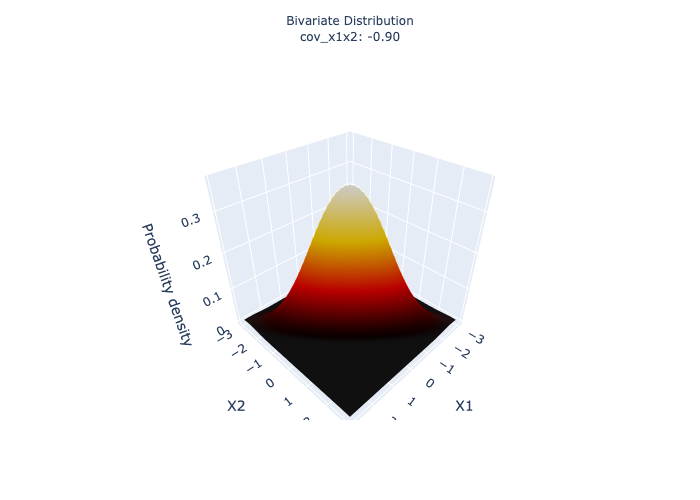

In [7]:
fig = go.Figure(
    go.Surface(
        z=neg_cov_res[2],
        x=x1,
        y=x2,
        colorscale='Hot',
        showscale=False
    )
)
fig.update_layout(
    {
        "title": dict(
            text=f"Bivariate Distribution<br>cov_x1x2: {neg_cov[0][1]:.2f}",
            y=0.95,
            x=0.5,
            xanchor="center",
            yanchor="top",
            font=dict(size=12)
        ), 
        "scene":dict(
            xaxis=dict(title='X1'),
            yaxis=dict(title='X2'),
            zaxis=dict(title='Probability density')
        ),
        "xaxis": dict(title="Values"),
        "yaxis": dict(title="Probability Density"),
    }
)

fig.write_html(os.path.join(SAVE_PLOT_DIR, "bivariate_negative_covariance_density.html"))
fig.write_image(os.path.join(SAVE_PLOT_DIR, "bivariate_negative_covariance_density.png"))
fig.show("png")

[Click here](https://aakashkumarnain.github.io/images/images_from_other_repos/diffusion_models/plots/bivariate_negative_covariance_density.html) to see the **interactive plot.**

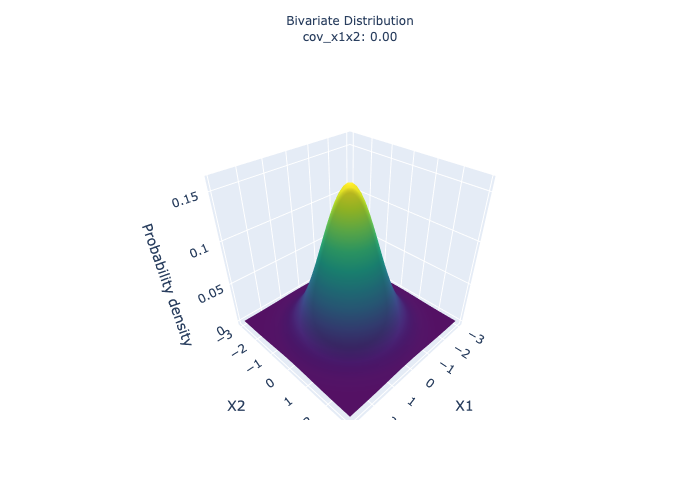

In [8]:
fig = go.Figure(
    go.Surface(
        z=zero_cov_res[2],
        x=x1,
        y=x2,
        colorscale='Viridis',
        showscale=False
    )
)
fig.update_layout(
    {
        "title": dict(
            text=f"Bivariate Distribution<br>cov_x1x2: {zero_cov[0][1]:.2f}",
            y=0.95,
            x=0.5,
            xanchor="center",
            yanchor="top",
            font=dict(size=12)
        ), 
        "scene":dict(
            xaxis=dict(title='X1'),
            yaxis=dict(title='X2'),
            zaxis=dict(title='Probability density')
        ),
        "xaxis": dict(title="Values"),
        "yaxis": dict(title="Probability Density"),
    }
)

fig.write_html(os.path.join(SAVE_PLOT_DIR, "bivariate_zero_covariance_density.html"))
fig.write_image(os.path.join(SAVE_PLOT_DIR, "bivariate_zero_covariance_density.png"))
fig.show("png")

[Click here](https://aakashkumarnain.github.io/images/images_from_other_repos/diffusion_models/plots/bivariate_zero_covariance_density.html) to see the **interactive plot.**

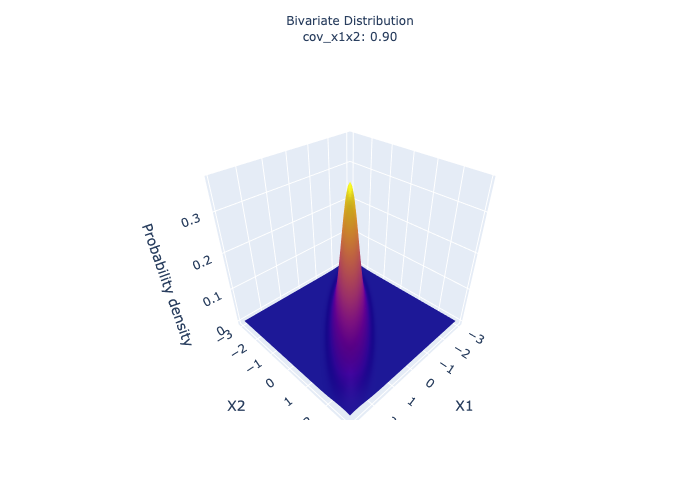

In [9]:
fig = go.Figure(
    go.Surface(
        z=pos_cov_res[2],
        x=x1,
        y=x2,
        showscale=False
    )
)
fig.update_layout(
    {
        "title": dict(
            text=f"Bivariate Distribution<br>cov_x1x2: {pos_cov[0][1]:.2f}",
            y=0.95,
            x=0.5,
            xanchor="center",
            yanchor="top",
            font=dict(size=12)
        ), 
        "scene":dict(
            xaxis=dict(title='X1'),
            yaxis=dict(title='X2'),
            zaxis=dict(title='Probability density')
        ),
        "xaxis": dict(title="Values"),
        "yaxis": dict(title="Probability Density"),
    }
)

fig.write_html(os.path.join(SAVE_PLOT_DIR, "bivariate_positive_covariance_density.html"))
fig.write_image(os.path.join(SAVE_PLOT_DIR, "bivariate_positive_covariance_density.png"))
fig.show("png")

[Click here](https://aakashkumarnain.github.io/images/images_from_other_repos/diffusion_models/plots/bivariate_positive_covariance_density.html) to see the **interactive plot.**

A few things to note in the above surface plots:

1. The plot with zero covariance is circular in every direction.
2. The plots with negative and positive covariances are more flattened on the 45-degree line, and are somewhat in a perpendicular direction to that line visually.

# 3. Isotropic Gaussian

An isotropic Gaussian is one where the covariance matrix $\Sigma$ can be represented in this form:
$$
\Sigma = \sigma^2 I  \tag{4}
$$

1. $I$ is the Identity matrix
2. $\sigma^2$ is the scalar variance 

**Q**: Why do we want to represent the covarince matrix in this form?<br/>
**A**: As the dimensions of a multivariate Gaussian grows, the **mean** $\mu$ follows a linear growth where the **covarince matrix** $\Sigma$ follows quadratic growth in terms of number of parameters. This quadratic growth isn't computation friendly. A **diagonal covariance matrix** makes things much easier

A few things to note about isotropic Gaussian:

1. *Eq. (4)* represents a diagonal matrix multiplied by a scalar variance. This means that the **variance** along each dimension is equal. Hence an *isotropic multivariate Gaussian* is **circular** or **spherical**.

2. We discussed that `Cov(x1, x2)=0` doesn't mean `x1` and `x2` are independent but if the distribution is **multivariate normal** and `Cov(x1, x2)=0`, it implies that `x1` and `x2` are independent. 

3. If the multivariate distribution is isotropic, that means:
       i. Covariance Matrix is diagonal
       ii. The distribution can be represented as a product of univariate Gaussians i.e.
                P(X) = P(x1)P(x2)..
                
Let's take an example of an isotropic normal

In [10]:
# Mean of the random variables X1 and X2
mu_x1, mu_x2 = 0, 0

# Standard deviation of the random variables X1 and X2
# Remember the std. is going to be the same
# along all the dimensions.
sigma_x1 = sigma_x2 = 2

# Number of samples to extract
sample_size = 5000

# Positions for which probability density is
# to be generated
x1, x2 = np.mgrid[
    (-3.0 * sigma_x1 + mu_x1):(3.0 * sigma_x1 + mu_x1): 0.1,
    (-3.0 * sigma_x2 + mu_x2):(3.0 * sigma_x2 + mu_x2): 0.1
]
pos = np.dstack((x1, x2))

# Mean vector
mu = [mu_x1, mu_x2]


# Because the covariance matrix of an multivaraite isotropic
# gaussian is a diagonal matrix, hence the covariance for 
# the dimension will be zero.
cov_x1x2 = 0
cov = [[sigma_x1**2, cov_x1x2], [cov_x1x2, sigma_x2**2]]


isotropic_gaussian = get_multivariate_normal(
                        mu=mu,
                        cov=cov,
                        sample=True,
                        sample_size=sample_size,
                        seed=seed,
                        gen_pdf=True,
                        pos=pos
                    )

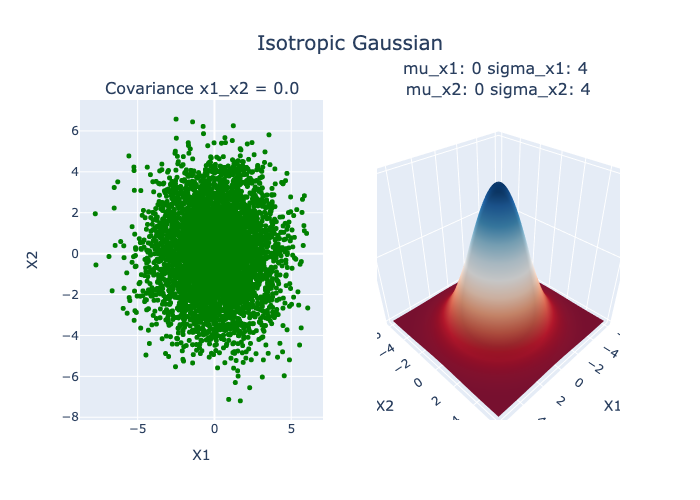

In [11]:
fig = make_subplots(
    rows=1, cols=2,
    shared_yaxes=False,
    shared_xaxes=False,
    specs=[[{'type': 'scatter'}, {'type': 'surface'}]],
    subplot_titles=(
        "Covariance x1_x2 = 0.0",
        f"mu_x1: {mu_x1} sigma_x1: {sigma_x1**2} <br>mu_x2: {mu_x2} sigma_x2: {sigma_x2**2}"
    )
)


fig.add_trace(
    go.Scatter(
        x=isotropic_gaussian[1][:, 0],
        y=isotropic_gaussian[1][:, 1],
        mode='markers',
        marker=dict(size=5, color="green"),
    ),
    row=1, col=1
)

fig.add_trace(
    go.Surface(
        z=isotropic_gaussian[2],
        x=x1,
        y=x2,
        colorscale='RdBu',
        showscale=False
    ),
    row=1, col=2
)

fig.update_layout(
    {
        "scene":dict(
            xaxis=dict(title='X1'),
            yaxis=dict(title='X2'),
            zaxis=dict(title='Probability density')
        ),
        "xaxis": {"title": "X1"},
        "yaxis": {"title": "X2"},
        "title": {"text": "Isotropic Gaussian", "x":0.5, "font":dict(size=20)}
    }
)

fig.write_html(os.path.join(SAVE_PLOT_DIR, "isotropic_gaussian.html"))
fig.write_image(os.path.join(SAVE_PLOT_DIR, "isotropic_gaussian.png"))
fig.show("png")

[Click here](https://aakashkumarnain.github.io/images/images_from_other_repos/diffusion_models/plots/isotropic_gaussian.html) to see the **interactive plot.**

# 4. Conditional Distribution 

Let's say we have a multivariate distribution over `x` where
$$
 x = \begin{bmatrix}x_{1}\\x_{2}\end{bmatrix} \\
 \mu = \begin{bmatrix}\mu_{1}\\\mu_{2}\end{bmatrix} \\
 \Sigma = \begin{bmatrix}\Sigma_{11} & \Sigma_{12} \\ \Sigma_{21} & \Sigma_{22}\end{bmatrix}
$$

Then the distribution of `x1` conditional on `x2=a` is multivariate normal:

$$
p(x1 | x2 = a) \sim N(\bar\mu, \bar\Sigma) \ \ \ \text  {where:}
$$

$$
\bar\mu = \mu_{1} + \ \Sigma_{12}\Sigma_{22}^{-1}(a - \mu_{2}) \tag{5}
$$
$$
\bar\Sigma = \Sigma_{11} - \ \Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21} \tag{6}
$$

<br/>
<br/>

But why are we discussing the conditional distribution? Do you need to remember these equations?

Well, first and foremost you don't have to mug up any of these equations. You can find them easily on Wikipedia. But there is a reason why we are discussing the conditional distributions here.

Let's say you have a process that takes the form of a [**Markov Chain**](https://setosa.io/ev/markov-chains/). For example, the forward process in **Diffusion Models** is one example of such a sequence. Let's write down the equation for the same.
$$
q(x_{1:T}\vert x_{0}) := \prod_{t=1}^{T}q(x_{t}\vert x_{t-1}) :=\prod_{t=1}^{T}\mathcal{N}(x_{t};\sqrt{1-\beta_{t}} x_{t-1},\ \beta_{t}\bf I) \tag{7}
$$

This equation tells us a few things:

1. The forward process is a Markov Chain where the sample at the present step depends only on the sample at the previous timestep.
2. The covariance matrix is **diagonal**
3. At each timestep in this sequence, we gradually **add** Gaussian noise. But this isn't very clear from the equation where is this addition taking place, right?
4. The term $\beta$ represents the variance at a *particular timestep `t`* such that $0 < \beta_{1} < \beta_{2} < \beta_{3} < ...  < \beta_{T} < 1$

To understand the last point, let's make some assumptions to simplify the eq (7).<br/>
1. We will ignore the variance schedule $\beta$ for now. We can rewrite the above equation as: $$q(x_{1:T}\vert x_{0}) := \prod_{t=1}^{T}q(x_{t}\vert x_{t-1}) :=\prod_{t=1}^{T}\mathcal{N}(x_{t}; x_{t-1},\ \bf I)  \tag{8}$$
2. We will consider `x` as a univariate normal. This assumption is made only to give readers a better understanding of the conditional Gaussian case. The same concept extends to multivariate normal.

With the above assumptions in mind, combined with the `Law of total probability`, we can write the equation as:

$$p(x_{t}) = \int p(x_{t} \vert \ x_{t-1})p(x_{t-1})dx_{t-1} \tag {9}$$

Using *(8)*, we can rewrite this as:
$$p(x_{t}) = \int \mathcal{N}(x_{t}; \ x_{t-1}, 1) p(x_{t-1})dx_{t-1} \tag {10}$$

Because we are dealing with univariate normal, the identity matrix is nothing but a scalar value of 1. Moving forward, we can shift the terms in the above equation like this:
$$p(x_{t}) = \int \mathcal{N}(x_{t} - x_{t-1}; \ 0, 1) p(x_{t-1})dx_{t-1} \tag {11}$$

Notice two things that we got by this shift:
1. The mean and the variance values of the distribution on the right-hand side are `0` and `1` respectively.
2. If you look closely at the term on the RHS in the above equation, you will notice that it is the definition of **convolution**.

Combining the above two facts, we can rewrite *(11)* as:
$$p(x_{t}) = \mathcal{N}(0, 1) \ * \ p(x_{t-1}) \tag {12}$$

**Property**: The convolution of individual distributions of two or more random variables equals the sum of the random variables.

$$ \Longrightarrow x_{t} = \mathcal{N}(0, 1) \ + \ x_{t-1} \tag {13}$$

We will prove the above property in the next section, but this is one of the things that you should remember. Also, we hope that it is clear now why conditioned distributions in the forward process of Diffusion models are equivalent to "adding Gaussian noise" to previous timesteps. Don't worry about the diffusion models related equations and terms like `variance schedule`. We will talk about them in detail in the upcoming notebooks.

# 5. Convolution of probability distributions

In the last section we stated that the convolution of individual distributions of two or more random variables equals the sum of the random variables. To prove this, we will take an example of two normally distributed random variables `X` and `Y`. If `X` and `Y` are two normally distributed independent random variables such that

$$
X \sim \mathcal{N}(\mu_{1}, \sigma_{1}^2) \\
Y \sim \mathcal{N}(\mu_{2}, \sigma_{2}^2) \\
$$

$\text{if} \ Z = X + Y  \Longrightarrow Z \sim \mathcal{N}(\mu_{1} + \mu_{2}, \sigma_{1}^2 +\sigma_{2}^2) \tag{14}$ 

Our goal is to prove that if we convolve the PDFs of `X` and `Y`, then the resulting distribution would be identical to the distribution of `Z`. Let's write down the code for it.

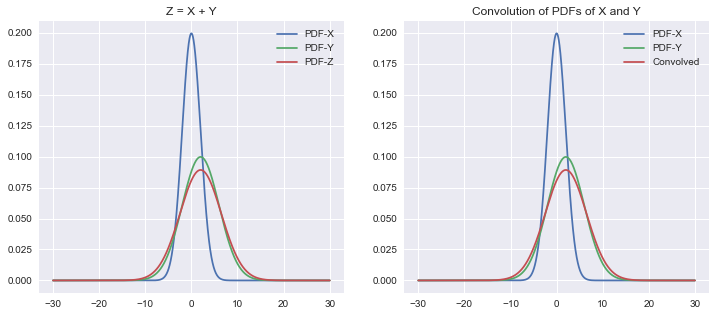

In [12]:
# Mean and Standard deviation of X
mu_x = 0.0
sigma_x = 2.0

# Mean and Standard deviation of Y
mu_y = 2.0
sigma_y = 4.0

# Mean and Standard deviation of Z
mu_z = mu_x + mu_y
sigma_z = np.sqrt(sigma_x**2 + sigma_y**2)

# Get the distributions
dist_x = norm(loc=mu_x, scale=sigma_x)
dist_y = norm(loc=mu_y, scale=sigma_y)
dist_z = norm(loc=mu_z, scale=sigma_z)

# Generate the PDFs
step_size = 1e-4
points = np.arange(-30, 30, step_size)

pdf_x = dist_x.pdf(points)
pdf_y = dist_y.pdf(points)
pdf_z = dist_z.pdf(points)


# NOTE: We cannot convolve over continous functions using `numpy.convolve(...)`
# Hence we will discretize our PDFs into PMFs using the step size we defined above
pmf_x = pdf_x * step_size
pmf_y = pdf_y * step_size

# Convolve the two PMFs
conv_pmf = np.convolve(pmf_x, pmf_y, mode="same")
conv_pdf = conv_pmf / step_size


# Let's plot the distributions now and check if we have gotten
# the same distribution as Z. 
# NOTE: As we have approximated PMF from PDF, there would be
# erros in the approximation. So, the final result may not
# look 100% identical.

_, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 5))

ax[0].plot(points, pdf_x)
ax[0].plot(points, pdf_y)
ax[0].plot(points, pdf_z)
ax[0].set_title("Z = X + Y")
ax[0].legend(["PDF-X", "PDF-Y", "PDF-Z"])

ax[1].plot(points, pdf_x)
ax[1].plot(points, pdf_y)
ax[1].plot(points, pdf_z)
ax[1].set_title("Convolution of PDFs of X and Y")
ax[1].legend(["PDF-X", "PDF-Y", "Convolved"])

plt.savefig(os.path.join(SAVE_PLOT_DIR, "convolution_of_pdfs.png"))
plt.show()

# 6. The Forward Process

Though we will talk about `Diffusion Models` in detail in the future posts as well, I will implement the forward process here to give you an idea that things that might look complicated in symbols aren't that complicated in terms of code.

Let's rewrite the forward process equation again:

$$
q(x_{1:T}\vert x_{0}) := \prod_{t=1}^{T}q(x_{t}\vert x_{t-1}) :=\prod_{t=1}^{T}\mathcal{N}(x_{t};\sqrt{1-\beta_{t}} x_{t-1},\ \beta_{t}\bf I)
$$

To implement the above equation:

1. We have to define the total number of timesteps `T`
2. We have to generate $\beta_{t}$ using a schedule. We can use any schedule including but not limited to linear, quadratic, etc. The only thing that we need to ensure is that $\beta_{1} < \beta_{2}...$
3. Sample a new image at timestep `t` from a conditional Gaussian for which the paramters are $\mu_{t} = \sqrt{1-\beta_{t}} x_{t-1}$ and $\sigma_{t}^2 = \beta_{t}$
4. For the last point, we can use the property(eq. (13)) we studied in the conditional distribution section. Hence we can write this as:

$$x_{t} \sim (\mathcal{N}(\sqrt{1-\beta_{t}} x_{t-1},\ \beta_{t}) + \mathcal{N}(0, 1))$$

$$
\Rightarrow x_{t} = \sqrt{1-\beta_{t}} x_{t-1} + \sqrt{\beta_{t}}\epsilon \ \ ; \ \text{where} \ \epsilon \sim \mathcal{N}(0, 1) \tag{15}
$$

Now that we have broken down the equation in much simpler parts, let's code it!

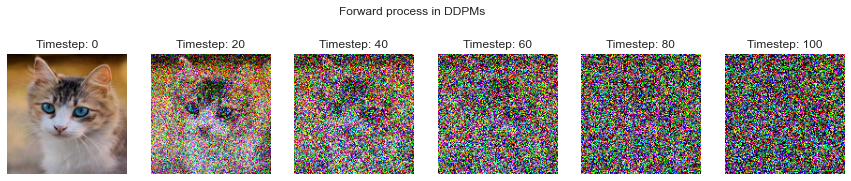

In [15]:
def forward_process_ddpms(img_t_minus_1, beta, t):
    """Implements the forward process of a DDPM model.
    
    Args:
        img_t_minus_1: Image at the previous timestep (t - 1)
        beta: Scheduled Variance
        t: Current timestep
    Returns:
        Image obtained at current timestep
    """
    
    # 1. Obtain beta_t. Reshape it to have the same number of
    # dimensions as our image array
    beta_t = beta[t].reshape(-1, 1, 1)
    
    # 2. Calculate mean and variance
    mu = np.sqrt((1.0 - beta_t)) * img_t_minus_1
    sigma = np.sqrt(beta_t)
    
    # 3. Obtain image at timestep t using equation (15)
    img_t = mu + sigma * np.random.randn(*img_t_minus_1.shape)
    return img_t


# Let's check if ourforward process function is
# doing what it is supposed to do on a sample image

# 1. Load image using PIL (or any other library that you prefer)
img = Image.open("./images/cat.jpg")

# 2. Resize the image to desired dimensions
IMG_SIZE = (128, 128)
img = img.resize(size=IMG_SIZE)

# 3. Define number of timesteps
timesteps = 100

# 4. Generate beta (variance schedule)
beta_start = 0.0001
beta_end = 0.05
beta = np.linspace(beta_start, beta_end, num=timesteps, dtype=np.float32)


processed_images = []
img_t = np.asarray(img.copy(), dtype=np.float32) / 255.

# 5. Run the forward process to obtain img after t timesteps
for t in range(timesteps):
    img_t = forward_process_ddpms(img_t_minus_1=img_t, beta=beta, t=t)
    if t%20==0 or t==timesteps - 1:
        sample = (img_t.clip(0, 1) * 255.0).astype(np.uint8)
        processed_images.append(sample)

# 6. Plot and see samples at different timesteps
_, ax = plt.subplots(1, len(processed_images), figsize=(15, 6))

for i, sample in enumerate(processed_images):
    ax[i].imshow(sample)
    ax[i].set_title(f"Timestep: {i*20}")
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Forward process in DDPMs", y=0.75)
plt.savefig(os.path.join(SAVE_PLOT_DIR, "forward_process.png"))
plt.show()
plt.close()

One thing to note here is that as you increase the number of timesteps `T`, $\beta_{t} \to 1$. At that point:

$$q(x_{T}) \approx \mathcal{N}(x_{T};\ 0, I)$$


That's it for now. We will talk about reverse process and other things related to DDPMs in the future notebooks. I hope this notebook was enough to give you a solid understanding of **Gaussian distribution** and their usage in context of DDPMs.


# References:

* https://en.wikipedia.org/wiki/Normal_distribution
* https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Likelihood_function
* https://en.wikipedia.org/wiki/Convolution_of_probability_distributions
* https://online.stat.psu.edu/stat505/lesson/6/6.1
* https://www.inf.ed.ac.uk/teaching/courses/pmr/slides/cts4up.pdf
* http://timstaley.co.uk/posts/convolving-pdfs-in-python/
* https://www.assemblyai.com/blog/diffusion-models-for-machine-learning-introduction/
* https://www.youtube.com/watch?v=fbLgFrlTnGU&t=317s
* https://people.eecs.berkeley.edu/~jrs/189s17/lec/09.pdf
* https://mmuratarat.github.io/2019-10-05/univariate-multivariate_gaussian
* https://math.stackexchange.com/questions/4492913/isotropic-gaussian
* https://cs229.stanford.edu/section/gaussians.pdf
* https://math.stackexchange.com/questions/1991961/gaussian-distribution-is-isotropic
* https://www.cse.psu.edu/~rtc12/CSE586Spring2010/papers/prmlGaussian.pdf
* https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html
* https://docs.scipy.org/doc/scipy/tutorial/stats.html
* https://www.deeplearningbook.org/contents/prob.html
* https://arxiv.org/abs/2006.11239